In [1]:
import pandas as pd
import string
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import re
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## *Step 1*: Load the data of preprocessing Notebook


In [4]:
x_train_file = open('/content/drive/My Drive/X_train.pkl', 'rb')
X_train = pickle.load(x_train_file)

x_test_file = open('/content/drive/My Drive/X_test.pkl', 'rb')
X_test = pickle.load(x_test_file)

y_train_file = open('/content/drive/My Drive/Y_train.pkl', 'rb')
Y_train = pickle.load(y_train_file)

y_test_file = open('/content/drive/My Drive/Y_test.pkl', 'rb')
Y_test = pickle.load(y_test_file)

x_val_file = open('/content/drive/My Drive/X_val.pkl', 'rb')
X_val = pickle.load(x_val_file)

y_val_file = open('/content/drive/My Drive/Y_val.pkl', 'rb')
Y_val = pickle.load(y_val_file)

## *Step 2:* Vectorization with pre-trained word embendding vectors using GloVe

Here I download the glove.6B.50d.txt file, in which there is about 400 words represented by vectors of 50 dimensions. If we printed the content of the file, we could see that each line contain as first element a word followed by 50 real numbers. 

---

I need to parse the file to get as output: list of words, dictionary mapping each word to their id (position) and array of vectors.

In [5]:
words = []
idx = 0
word2idx = {}
vectors = []

with open(f'/content/drive/My Drive/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

glove = {w: vectors[word2idx[w]] for w in words}

In [7]:
# Save GloVe dictionary.
glove_file = open("/content/drive/My Drive/glove_dict_50d.pkl", "wb")
pickle.dump(glove,glove_file)
glove_file.close()

# Load GloVe dictionary.
glove_file = open("/content/drive/My Drive/glove_dict_50d.pkl", "rb")
glove = pickle.load(glove_file)
# glove_file.close()

####I build a matrix of weights with shape will be equal to (dataset’s vocabulary length, word vectors dimension).

---

####For each word in dataset’s vocabulary, I checked if it is on glove’s vocabulary. If there is, I load its pre-trained word vector. Otherwise, I initialized it with zeros. Finally, I find the mean vector of each tweet. This is a technique that we learned and applied in lesson of Data Mining and I borrowed it from my older projects of this lesson.

In [8]:
def Vectors_from_Glove(dataset):
  matrix_len = dataset['text'].str.split().str.len().sum()
  # print(matrix_len)
  words_found = 0
  words = 0
  mean_tweets = []

  for i,row in enumerate(dataset['text']):
    splited_words = str(row).split(' ')
    weight_matrix = np.zeros((len(splited_words),50))
    for j,word in enumerate(splited_words): 
      words += 1
      if word in glove:
        weight_matrix[j] = glove[word]
        words_found += 1
    mean_tweets.append(np.mean(weight_matrix,axis=0))

  return np.array(mean_tweets), words_found, matrix_len

####Print the ratio of words that founded in glove on train, validation and test set. We see that we found 93% of words in our tweets, which is is a very satisfying score.

In [9]:
gloveX_train, words_found, matrix_len = Vectors_from_Glove(pd.DataFrame(X_train))
print(gloveX_train.shape)
# print(type(gloveX_train))
# print(len(gloveX_train[0]))  
# print(gloveX_train[0])
print("Ratio of words that have founded in Glove: ", round(words_found/matrix_len,2))

gloveX_val, words_found, matrix_len = Vectors_from_Glove(pd.DataFrame(X_val))
print("Ratio of words that have founded in Glove: ", round(words_found/matrix_len,2))

gloveX_test, words_found, matrix_len = Vectors_from_Glove(pd.DataFrame(X_test))
print("Ratio of words that have founded in Glove: ", round(words_found/matrix_len,2))


(1267232, 50)
Ratio of words that have founded in Glove:  0.93
Ratio of words that have founded in Glove:  0.93
Ratio of words that have founded in Glove:  0.93


## *Step 3*: Convert to tensors

In [10]:
# Convert X datasets to tensors with function convert_to_tensor.
gloveX_train = torch.tensor(gloveX_train)
gloveX_val = torch.tensor(gloveX_val)
gloveX_test = torch.tensor(gloveX_test)

In [11]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

## *Step 4*: Use Cuda

Here I use the GPU (whenever I can) that google colab offer to its users. 

In this case I can run the colab notebook for all the dataset without GPU (ie the CPU) without have memory crashed. This is due to the fact that now I have much less dimensions (only 50) against to 1000 that I have in my first model. However, in any case if I use cuda it run much faster.

In [12]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## *Step 5*: Built the 2nd Model

####In my second model I select to have 2 hidden layers (just like the first model so I can easily compare them), with each size of hidden units to be 64 and 16 respectively. So I have again a non deep Neural Network. I tried several combinations of numbers of hidden units, but I think this is the best option to not have overfitting.

In [13]:
class Feed_forward_Neural_NetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Feed_forward_Neural_NetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim_1)
        # self.dropout1 = nn.Dropout(0.5)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # self.batch2 = nn.BatchNorm1d(hidden_dim_2)
        # self.dropout2 = nn.Dropout(0.5)

        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3 
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)
        
        return torch.sigmoid(out)

## *Step 6*: Initialize the 1st Model

As you can see I select 
- 80 epochs, learning rate 1e-4 and weight decay 1e-4. 
- For the loss function, I select the BCELoss(), because this is the best option if we have binary classification.
- As optimizer I select Adam, since I read that it has the best performance. Althouth I tried other optimizers, the score doesn't changed.


In [14]:
# Dimensions of each layer and num of epochs.
input_dim = gloveX_train.shape[1]
hidden_dim_1 = 64
hidden_dim_2 = 16
output_dim = 1
num_epochs = 80

# Define our first feed forward neural network.
second_model = Feed_forward_Neural_NetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
# optimizer = optim.Adamax(second_model.parameters(),lr=0.00001,weight_decay=1e-3)
# optimizer = optim.AdamW(second_model.parameters(),lr=0.00001,weight_decay=1e-3)
# optimizer = optim.SGD(second_model.parameters(),lr=0.00001,weight_decay=1e-3)
# optimizer = optim.RMSprop(second_model.parameters(),lr=0.00001,weight_decay=1e-3)
optimizer = optim.Adam(second_model.parameters(),lr=1e-4,weight_decay=1e-4)

# Transfer all the computation to GPU (cuda device).
second_model.to(device)
criterion = criterion.to(device)

## *Step 7*: Train the 2nd Model

I trained the model just like the first one, with the same batch size.

In [15]:
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 10000

# Split train dataset to mini batches
X_train_mini_batches = torch.split(gloveX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = second_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients 
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    gloveX_val = gloveX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = second_model.forward(gloveX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss += val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    # print("Epoch:",epoch, "\n"
    #       "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
    #       "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")
    

## *Step 8*: Plot loss vs epochs and accuracy vs epochs 

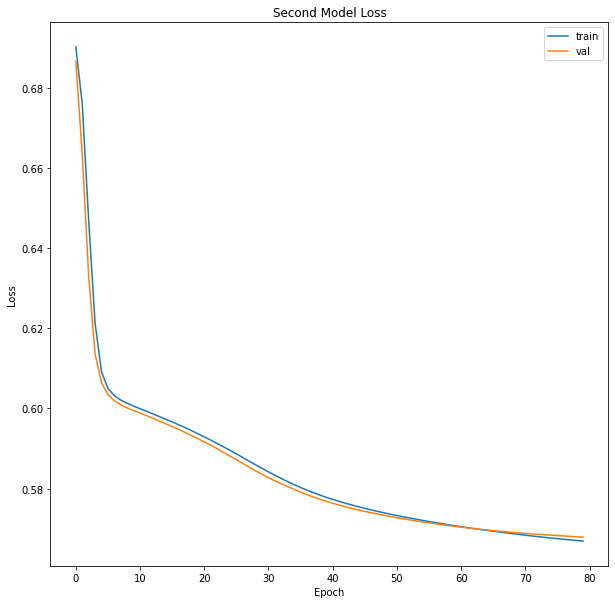

In [16]:
figure(figsize=(10,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Second Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

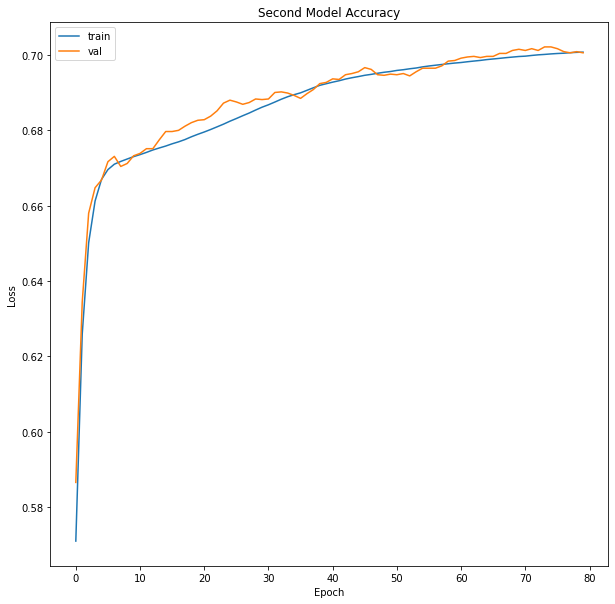

In [17]:
figure(figsize=(10,10)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Second Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####As you can see there is neither **overfitting** nor **underfitting**, while the training and validation loss decreases to a point of stability with a minimal gap between the two final loss values. I observed that if I continued with more epochs the plot of training loss continues to decrease with experience and the plot of validation loss decreases to a point and begins increasing again (which means that we have the phenomenon of overfitting). So I decide to stop to 80 epochs as we have a **good fit**.
---
####If you look carefully, you can see that the model converges approximately in epoch 60. So the **second model** needs at least 60 epochs to reach the minimun cost of 0.55. We should remember this in order to compare this with the other models.

## *Step 9*: Calculate the accuracy on test set  

Here I calculate the accuracy on test set manually and also show the classification report.

In [18]:
gloveX_test = gloveX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = second_model.forward(gloveX_test.float())
test_prediction = torch.squeeze(test_prediction)

# Add each mini batch's accuracy
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7048 



In [19]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      3240
         1.0       0.70      0.70      0.70      3160

    accuracy                           0.70      6400
   macro avg       0.70      0.70      0.70      6400
weighted avg       0.70      0.70      0.70      6400



In [20]:
#Close the pickle files.
x_train_file.close()
y_train_file.close()
x_test_file.close()
y_test_file.close()
x_val_file.close()
y_val_file.close()

  ## *Step 10*: Summaries

- We notice that the second model gives score of 0.70. In order to reach to this score, without overfitting or underfitting, it needed at least 60 epochs to reach the minimun cost.

- When I have overfitting I tried the technique of Dropout and Batch Normalize but it didn't help me again, because the only thing that happened is the cost fluctuate over the training examples and it wasn't so quite smooth just now. I end up to the coclusion that techniques such as Dropout and Batch Normalize doesn't help us, because our dataset is pretty much "easy" for our model.

- I have to mention that in order to run all the colab notebook with no crashed memory, I load all of our dataset, without any problem this time because of the little amount of dimensions 50 against to 1000 (with tf-idf).

- As you can observe this model didn't go as well as we expected. Due to pre-trained word embedding glove, I expected the model to do better work than the tf-idf model. However, the second model gives me score of 70% and minimum cost 0.55. Although it reach this cost in less epochs (60 against to 120 of the first model), the score is much worse than the first one of 79% and I didn't see any improvement (nor in cost). For this reason, I choose the first model with tf-idf over the second one with glove to continue with the experimentation.

- When I thought about it again, I realize that it is logical that the first model go better than the second model with glove, because in the first case we use 1000 dimensions and it is too much information over only 50 with glove. 